In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import yaml

from typing import List, Dict, Any
from pathlib import Path


# local imports
from src.data_processing.model_analyzers.elastic_net_analyzers.elastic_net_analyzer import MetricAnalyzer, FeatureImportanceAnalyzer
from src.data_processing.model_analyzers.elastic_net_analyzers.path_finder import PathFinder

# Dopamine Only


da_only_path = '/projects/p31961/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg'
da_experimenter = XGBRegExperimenter(da_only_path, analyzer=XGBRegAnalyzer, results = XGBRegrResults)
da_experimenter.run_experiment(
    number_of_runs=20, cls_to_drop=['mouse_id', 'day'])

da_w_day_experimenter = XGBRegExperimenter(
    da_only_path, analyzer=XGBRegAnalyzer, results=XGBRegrResults)
da_w_day_experimenter.run_experiment(
    number_of_runs=20, cls_to_drop=['mouse_id'])

# analyzer.fit_best_xgb_model()
# analyzer.plot_model_results()
# 

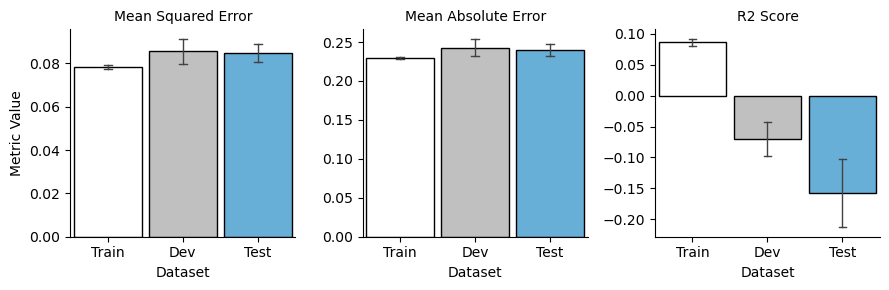

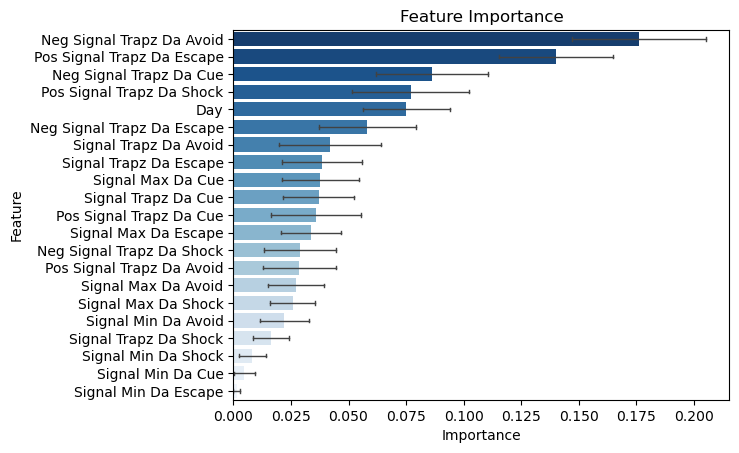

/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/xgb_regression_da_only_hyperopt_elastic_net/with_day_experiment_results/metric_results.parquet


,feature,importance,data_cat,with_day,is_net
0,Day,0.000000,feature_importance_results,True,False
18,Signal Trapz Da Cue,0.000000,feature_importance_results,True,False
17,Signal Trapz Da Avoid,0.000000,feature_importance_results,True,False
16,Signal Min Da Shock,0.000000,feature_importance_results,True,False
15,Signal Min Da Escape,0.000000,feature_importance_results,True,False
...,...,...,...,...,...
18,Signal Trapz Da Cue,0.123499,feature_importance_results,True,False
6,Pos Signal Trapz Da Cue,0.152988,feature_importance_results,True,False
7,Pos Signal Trapz Da Escape,0.153872,feature_importance_results,True,False
1,Neg Signal Trapz Da Avoid,0.156777,feature_importance_results,True,False


In [14]:
def analyze_and_plot_results(path:str):
    path = Path(path)
    path_finder = PathFinder(path)

    
    metrics_path = path_finder.metrics_paths[0]
    feature_path = path_finder.feature_importance_paths[0]
    feature_analyzer = FeatureImportanceAnalyzer(feature_path)
    net_analyzer = MetricAnalyzer(metrics_path)
    net_analyzer.read_and_clean_data()
    net_analyzer.plot_data()
    plt.show()
    feature_analyzer.read_and_clean_data()
    feature_analyzer.plot_data()
    plt.show()
    print(metrics_path, )
    
    return feature_analyzer.data_frame


da_path = '/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg'

analyze_and_plot_results(da_path)

# DA and D1

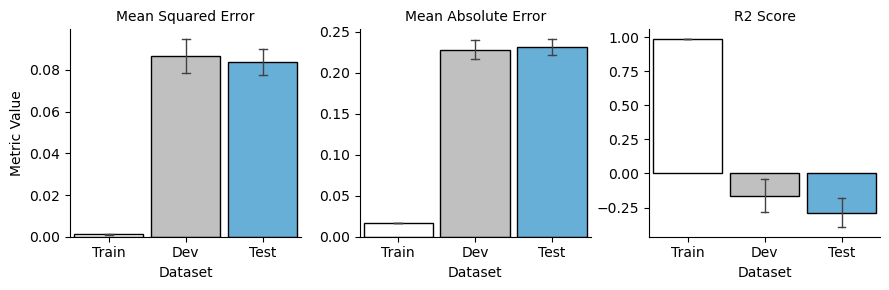

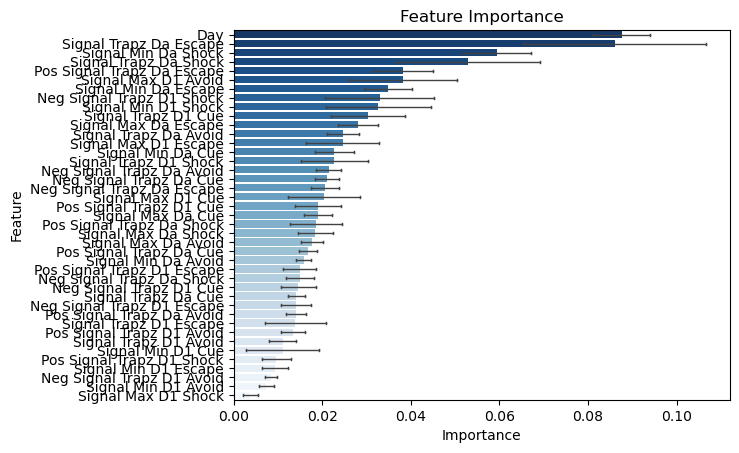

/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_and_d1_hyperopt_tune_with_elastic_net/with_day_experiment_results/metric_results.parquet /Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_and_d1_hyperopt_tune_with_elastic_net/with_day_experiment_results/feature_importance_results.parquet


,feature,importance,data_cat,with_day,is_net
28,Signal Min D1 Shock,0.000000,feature_importance_results,True,False
17,Signal Max D1 Avoid,0.000000,feature_importance_results,True,False
26,Signal Min D1 Cue,0.000000,feature_importance_results,True,False
27,Signal Min D1 Escape,0.000000,feature_importance_results,True,False
35,Signal Trapz D1 Escape,0.000000,feature_importance_results,True,False
...,...,...,...,...,...
0,Day,0.042870,feature_importance_results,True,False
36,Signal Trapz D1 Shock,0.073756,feature_importance_results,True,False
32,Signal Min Da Shock,0.076734,feature_importance_results,True,False
39,Signal Trapz Da Escape,0.119192,feature_importance_results,True,False


In [11]:
da_d1_path = '/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_and_d1_hyperopt_tune_with_elastic_net'
analyze_and_plot_results(da_d1_path)

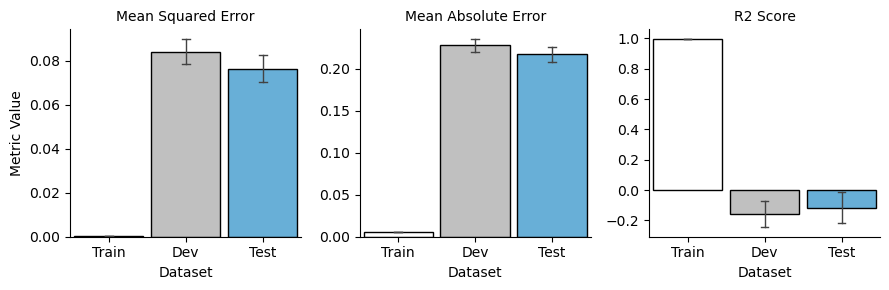

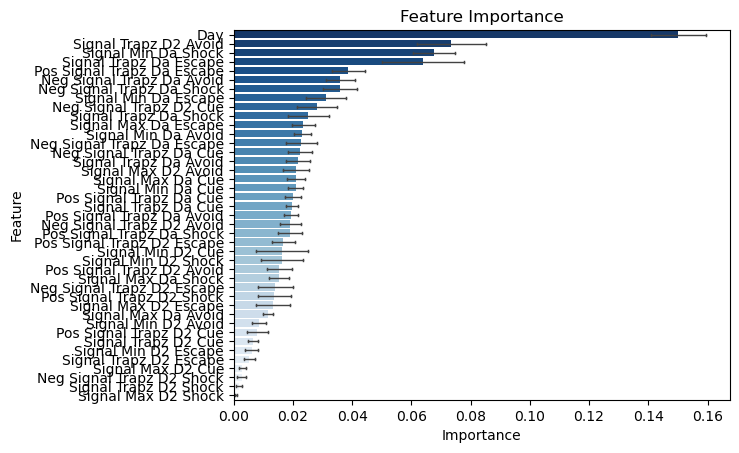

/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_and_d2_hyperopt_tune_with_elastic_net/with_day_experiment_results/metric_results.parquet /Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_and_d2_hyperopt_tune_with_elastic_net/with_day_experiment_results/feature_importance_results.parquet


,feature,importance,data_cat,with_day,is_net
12,Pos Signal Trapz D2 Shock,0.000000,feature_importance_results,True,False
36,Signal Trapz D2 Shock,0.000026,feature_importance_results,True,False
4,Neg Signal Trapz D2 Shock,0.000310,feature_importance_results,True,False
18,Signal Max D2 Cue,0.000408,feature_importance_results,True,False
27,Signal Min D2 Escape,0.000468,feature_importance_results,True,False
...,...,...,...,...,...
39,Signal Trapz Da Escape,0.083284,feature_importance_results,True,False
32,Signal Min Da Shock,0.090690,feature_importance_results,True,False
6,Neg Signal Trapz Da Cue,0.124391,feature_importance_results,True,False
0,Day,0.132404,feature_importance_results,True,False


In [12]:
da_d2_path = '/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_and_d2_hyperopt_tune_with_elastic_net'
analyze_and_plot_results(da_d2_path)